In [54]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# KMeans Cluster
from sklearn.cluster import KMeans

In [55]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


In [56]:
# Exploratory Group Bys
rachs_stay_days_gp = df[["rachs", "stay_days"]].groupby("rachs")
rachs = rachs_stay_days_gp.mean()
rachs["max"] = rachs_stay_days_gp.max()
rachs["min"] = rachs_stay_days_gp.min()

rachs_mortality = df[["rachs", "expired"]].groupby("rachs").sum()
# stay_days_rachs = pd.merge(stay_days_rachs, df["rachs"].value_counts())
rachs_count = df["rachs"].value_counts().sort_index()
rachs["patients"] = df["rachs"].value_counts().sort_values()
rachs["mortality"] = rachs_mortality
rachs["mortality_rate"] = (rachs["mortality"] / rachs["patients"]).map(lambda x: f"{100*x:,.2f}%")
# stay_days_rachs
rachs

,stay_days,max,min,patients,mortality,mortality_rate
rachs,,,,,,
0,17.100000,59,1,20,2,10.00%
1,2.932039,23,1,206,0,0.00%
2,8.591880,364,1,468,10,2.14%
3,13.316964,213,0,224,19,8.48%
4,18.767123,129,0,73,11,15.07%
5,34.000000,34,34,1,0,0.00%
6,67.909091,173,3,11,4,36.36%


In [57]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender", 
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days",
]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days
0,0,0,3942,35.0,134.0,0,1,2
1,1,1,3202,18.0,117.0,0,1,2
2,2,0,3147,22.0,120.0,0,1,2
3,3,0,4005,42.0,147.0,0,1,2
4,4,0,5289,40.0,157.0,0,1,3


In [58]:
# Load additional columns

df2 = pd.read_csv("../database/clean3/general_diagnosis_categories.csv")
df2.dropna(inplace=True)
df2.head()

,patient_id,diagnosis_general,categories_general
0,0,Ninguno,Ninguno
1,1,Ninguno,Ninguno
2,2,Ninguno,Ninguno
3,3,Ninguno,Ninguno
4,4,Ninguno,Ninguno


In [59]:
# BIN ALL COLUMNS THAT ARE UNDER A QUANTILE THRESHOLD
THRESHOLD = 0.988
df2["categories_general"] = kardiasclean.perform_binning_quantile(df2["categories_general"], THRESHOLD)
encoded_df = kardiasclean.perform_matrix_encoding(df2["categories_general"], df2["patient_id"], append_name=False)
print(encoded_df.shape)
encoded_df.head()

(1003, 10)


,patient_id,Ninguno,Other,Trisomia 21,Sindrome Dismorfologico E/E,Sindrome de Down,Sx dismorfologico,Hipotiroidismo,Epilepsia,Hipotiroidismo congenito
0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0


In [60]:
# Merge encoded data with original
merged_df = pd.merge(df, encoded_df)
merged_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Ninguno,Other,Trisomia 21,Sindrome Dismorfologico E/E,Sindrome de Down,Sx dismorfologico,Hipotiroidismo,Epilepsia,Hipotiroidismo congenito
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0


PCA

In [61]:
y = merged_df["stay_days"]
X = merged_df.drop(columns=["stay_days"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(1003, 16)

0.936852048773419

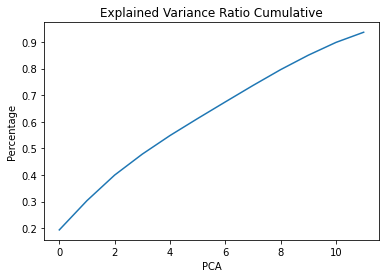

In [62]:
# Evaluate PCA
def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 12
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

**CONCLUSION:** We are not going to use the PCA, because cleaning was good.

## KMeans Clustering

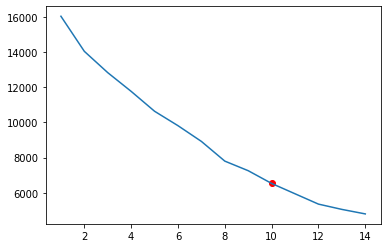

In [63]:
# Plot the Elbow curve
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 15)})
N_CLUSTERS = 10
plt.scatter(N_CLUSTERS, sse[N_CLUSTERS], color="red")
plt.plot(sse.index, sse.values)

In [64]:
# Create Clusters
model = KMeans(n_clusters=N_CLUSTERS, random_state=1).fit(X_scaled)
clusters = pd.Series(model.predict(X_scaled))
clusters.value_counts().sort_index()

0    158
1    341
2     87
3    289
4     18
5      8
6      8
7      8
8     20
9     66
dtype: int64

In [65]:
# Merge with ORIGINAL DATA
clustered_df = merged_df.copy(deep=True)
clustered_df["cluster"] = clusters
clustered_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Ninguno,Other,Trisomia 21,Sindrome Dismorfologico E/E,Sindrome de Down,Sx dismorfologico,Hipotiroidismo,Epilepsia,Hipotiroidismo congenito,cluster
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Average Stay Days')

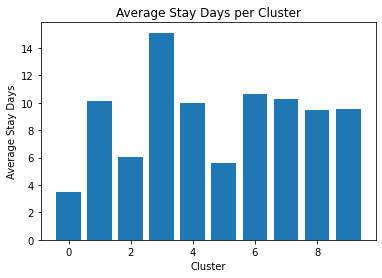

In [66]:
# Look at clusters
plot_data = clustered_df.groupby("cluster").mean()["stay_days"]
plot_x = plot_data.index
plot_y = plot_data.values
plt.bar(plot_x, plot_y)
plt.title("Average Stay Days per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stay Days")

In [67]:
# Create a Table of mean values per cluster
cluster_mean_df = pd.DataFrame()
target_names = ["stay_days", "rachs", "cx_previous", "age_days"]

# Process each cluster's data
for i in range(N_CLUSTERS):
    c_df = clustered_df[clustered_df["cluster"] == i]
    targets = [c_df[t].mean() for t in target_names]
    cluster_mean_df[f"Cluster {i+1}"] = [c_df.count()[0], *targets]

# Rename Index
cluster_mean_df.index = ["n_patients", *target_names]
# Transpose and Sort Data
sort_by = "stay_days"
cluster_mean_df = cluster_mean_df.transpose().sort_values(by=sort_by)
print("Table of Cluster x Mean Values")
cluster_mean_df

Table of Cluster x Mean Values


,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 1,158.0,3.462025,1.601266,0.063291,3948.082278
Cluster 6,8.0,5.625000,1.875000,0.250000,1902.500000
Cluster 3,87.0,6.057471,1.977011,0.022989,908.356322
Cluster 9,20.0,9.500000,1.950000,0.100000,975.450000
Cluster 10,66.0,9.545455,2.772727,1.651515,2393.575758
Cluster 5,18.0,9.944444,2.222222,0.166667,1078.000000
Cluster 2,341.0,10.117302,2.190616,0.052786,800.460411
Cluster 8,8.0,10.250000,2.250000,0.125000,1372.625000
Cluster 7,8.0,10.625000,2.375000,0.500000,1157.375000
Cluster 4,289.0,15.107266,2.391003,0.121107,733.709343


In [68]:
# Getting More stats per Column, spread in different tables
target_stats = ["mean", "std", "min", "max"]
for i in range(N_CLUSTERS):
    print("CLUSTER:", i)
    d = clustered_df[clustered_df["cluster"] == i]
    print(d[target_names].describe().loc[target_stats])

CLUSTER: 0
      stay_days     rachs  cx_previous      age_days
mean   3.462025  1.601266     0.063291   3948.082278
std    3.868271  0.748160     0.269076   1833.104050
min    0.000000  0.000000     0.000000   1803.000000
max   39.000000  4.000000     2.000000  16378.000000
CLUSTER: 1
       stay_days     rachs  cx_previous     age_days
mean   10.117302  2.190616     0.052786   800.460411
std    26.648436  0.952721     0.223934   644.285301
min     1.000000  0.000000     0.000000     1.000000
max   364.000000  6.000000     1.000000  2719.000000
CLUSTER: 2
      stay_days     rachs  cx_previous     age_days
mean   6.057471  1.977011     0.022989   908.356322
std    6.332559  0.681602     0.150736   774.822695
min    1.000000  1.000000     0.000000    77.000000
max   29.000000  3.000000     1.000000  3849.000000
CLUSTER: 3
       stay_days     rachs  cx_previous     age_days
mean   15.107266  2.391003     0.121107   733.709343
std    28.873026  1.116195     0.326818   790.590483
min    

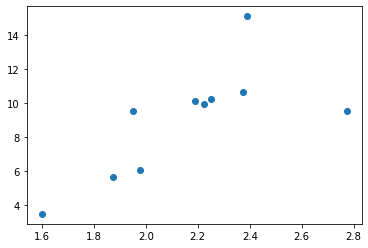

In [69]:
plt.scatter(cluster_mean_df['rachs'], cluster_mean_df['stay_days'])

In [70]:
# Format Results so they look better (They become strings)
cluster_mean_df.applymap(lambda x: f"{x:.2f}")

,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 1,158.00,3.46,1.60,0.06,3948.08
Cluster 6,8.00,5.62,1.88,0.25,1902.50
Cluster 3,87.00,6.06,1.98,0.02,908.36
Cluster 9,20.00,9.50,1.95,0.10,975.45
Cluster 10,66.00,9.55,2.77,1.65,2393.58
Cluster 5,18.00,9.94,2.22,0.17,1078.00
Cluster 2,341.00,10.12,2.19,0.05,800.46
Cluster 8,8.00,10.25,2.25,0.12,1372.62
Cluster 7,8.00,10.62,2.38,0.50,1157.38
Cluster 4,289.00,15.11,2.39,0.12,733.71


## Linear Regression

In [71]:
# Select Feature and Target
X = cluster_mean_df["rachs"].values.reshape(-1, 1)
y = cluster_mean_df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

((10, 1), (10, 1))

In [72]:
# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[5.47279651]])

In [73]:
# Predict and Evaluate Model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print(score)

r-squared: 0.44952898918585926
mean-squared error: 5.224106310603494
0.19821300666741615


Text(0, 0.5, 'Average Stay Days')

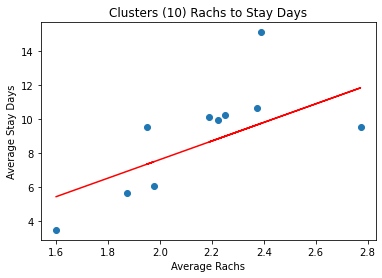

In [74]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title(f"Clusters ({N_CLUSTERS}) Rachs to Stay Days")
plt.xlabel("Average Rachs")
plt.ylabel("Average Stay Days")